In [1]:
import bz2

file_path = '/home/admin1/Project/Amazon Review/Data/train.ft.txt.bz2'
file_path_1 = '/home/admin1/Project/Amazon Review/Data/test.ft.txt.bz2'

with bz2.open(file_path_1, 'rt', encoding='utf-8') as f:
    for i, line in enumerate(f):
        print(line.strip())
        if i == 5:  
            break

__label__2 Great CD: My lovely Pat has one of the GREAT voices of her generation. I have listened to this CD for YEARS and I still LOVE IT. When I'm in a good mood it makes me feel better. A bad mood just evaporates like sugar in the rain. This CD just oozes LIFE. Vocals are jusat STUUNNING and lyrics just kill. One of life's hidden gems. This is a desert isle CD in my book. Why she never made it big is just beyond me. Everytime I play this, no matter black, white, young, old, male, female EVERYBODY says one thing "Who was that singing ?"
__label__2 One of the best game music soundtracks - for a game I didn't really play: Despite the fact that I have only played a small portion of the game, the music I heard (plus the connection to Chrono Trigger which was great as well) led me to purchase the soundtrack, and it remains one of my favorite albums. There is an incredible mix of fun, epic, and emotional songs. Those sad and beautiful tracks I especially like, as there's not too many of th

In [2]:
import bz2
import re
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from bs4 import BeautifulSoup
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt


In [3]:
texts = []
labels = []

with bz2.open(file_path, 'rt', encoding='utf-8') as f:
    for line in f:
        parts = line.strip().split(' ', 1)  # split label and text
        if len(parts) == 2:
            label, text = parts
            labels.append(label.replace('__label__', ''))  # remove FastText prefix
            texts.append(text)

In [4]:
print(len(texts))
print(len(labels))

3600000
3600000


In [5]:
texts_1 = []
labels_1 = []

with bz2.open(file_path_1, 'rt', encoding='utf-8') as f:
    for line in f:
        parts = line.strip().split(' ', 1)  # split label and text
        if len(parts) == 2:
            label_1, text_1 = parts
            labels_1.append(label_1.replace('__label__', ''))  # remove FastText prefix
            texts_1.append(text_1)

In [6]:
print(len(texts_1))
print(len(labels_1))

400000
400000


In [7]:
df_train = pd.DataFrame({'label': labels, 'text': texts})
print(df_train.head())
df_test = pd.DataFrame({'label': labels_1, 'text': texts_1})
print(df_test.head())

  label                                               text
0     2  Stuning even for the non-gamer: This sound tra...
1     2  The best soundtrack ever to anything.: I'm rea...
2     2  Amazing!: This soundtrack is my favorite music...
3     2  Excellent Soundtrack: I truly like this soundt...
4     2  Remember, Pull Your Jaw Off The Floor After He...
  label                                               text
0     2  Great CD: My lovely Pat has one of the GREAT v...
1     2  One of the best game music soundtracks - for a...
2     1  Batteries died within a year ...: I bought thi...
3     2  works fine, but Maha Energy is better: Check o...
4     2  Great for the non-audiophile: Reviewed quite a...


<Axes: xlabel='label', ylabel='Count'>

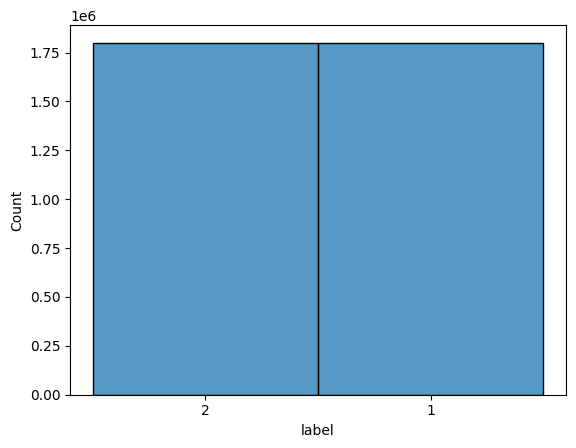

In [8]:
sns.histplot(df_train['label'])

In [9]:
nltk.download('punkt_tab')
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package punkt_tab to /home/admin1/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to /home/admin1/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /home/admin1/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [10]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def custom_analyzer(text):
    text = BeautifulSoup(text, "html.parser").get_text()
    text = re.sub(r'[^a-zA-Z\s]', '', text.lower())
    tokens = nltk.word_tokenize(text)
    return [lemmatizer.lemmatize(w) for w in tokens if w not in stop_words]

tfidf = TfidfVectorizer(
    analyzer=custom_analyzer,
    ngram_range=(1,1),
    max_features=10_000
)

X_train = tfidf.fit_transform(df_train['text'])
X_test = tfidf.fit_transform(df_test['text'])

In [11]:
y_train = df_train['label']
y_test = df_test['label']

In [12]:
print("Vocabulary size:", len(tfidf.get_feature_names_out()))

Vocabulary size: 10000


In [13]:
feature_names = tfidf.get_feature_names_out()
avg_tfidf = X_train.mean(axis=0).A1  # average score for each term across all docs

top_words = pd.DataFrame({
    'term': feature_names,
    'avg_tfidf': avg_tfidf
}).sort_values(by='avg_tfidf', ascending=False).head(20)

print(top_words)

             term  avg_tfidf
939         bonus   0.039473
6058          oil   0.023243
3858     grandson   0.022463
3779         goal   0.020886
5097        lifei   0.019213
5717  motherboard   0.018572
9901      wouldve   0.016369
9013         tied   0.016335
7031        ratio   0.016253
3711     genocide   0.015398
5225        loser   0.013952
9878       worker   0.013862
2580       domain   0.013606
6754     priority   0.013300
7052        react   0.013236
1316        cause   0.012553
9737        welli   0.011794
5728     motorola   0.011488
1155     business   0.011380
223         alarm   0.011080


<Axes: xlabel='text', ylabel='Density'>

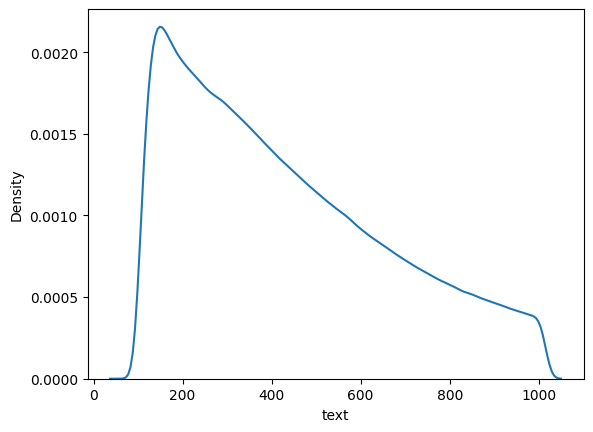

In [14]:
Len = df_train['text'].apply(len)
sns.kdeplot(Len)

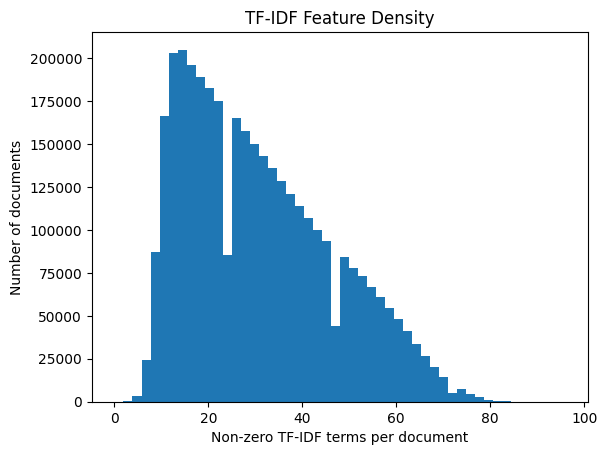

In [15]:
nonzero_counts = (X_train > 0).sum(axis=1).A1

plt.hist(nonzero_counts, bins=50)
plt.xlabel("Non-zero TF-IDF terms per document")
plt.ylabel("Number of documents")
plt.title("TF-IDF Feature Density")
plt.show()

In [16]:
print("Sparsity: {:.2f}%".format(100 * (1.0 - X_train.count_nonzero() / (X_train.shape[0] * X_train.shape[1]))))

Sparsity: 99.69%


In [17]:
rf_model = RandomForestClassifier(
    n_estimators=50,       # fewer trees to start
    max_depth=15,          # prevent deep trees
    n_jobs=-1,             # use all 12 CPU threads
    verbose=1,             # show progress
    random_state=42
)
rf_model.fit(X_train,y_train)
rf_model.score(X_test,y_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  3.7min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.7s
[Parallel(n_jobs=12)]: Done  50 out of  50 | elapsed:    1.2s finished


0.56884

In [19]:
y_pred = rf_model.predict(X_test)
print(classification_report(y_test,y_pred))

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.3s
[Parallel(n_jobs=12)]: Done  50 out of  50 | elapsed:    0.5s finished


              precision    recall  f1-score   support

           1       0.63      0.33      0.44    200000
           2       0.55      0.80      0.65    200000

    accuracy                           0.57    400000
   macro avg       0.59      0.57      0.54    400000
weighted avg       0.59      0.57      0.54    400000

